# Model de diffusion dans un canal étroit 

Code origine : $\mathrm{\color{red}{Cumulant4\_fonction.py}}$ et  $\mathrm{\color{red}{DoubleRigidWallOverBrow\_TheoVerification\_Cython.pyx}}$.

Auteur : $\mathrm{\color{purple}{Élodie ~MILLAN}}$

Date : 14/01/2022


- $2H_p$ : hauteur du canal;
- $a$ : rayon de la particule;
- On pose $H = H_p -a$
- $\eta_0$ : viscosité du fluide
- $D_\|(z) = \frac{k_\mathrm{B}T}{6 \pi \eta_\| a}$ : coeficient de diffusion colinéaire au mur, avec $\eta_\| (z) = \eta_0 \left( 1 - \frac{9a}{16(z+a)} +  \left( \frac{a}{8(z+a)} \right)^3 - \left( \frac{45a}{256(z+a)} \right)^4 - \left( \frac{a}{16(z+a)} \right)^5 \right)^{-1}$. 
- $D_\perp(z) = \frac{k_\mathrm{B}T}{6 \pi \eta_\perp a}$ : coeficient de diffusion transverse au mur, avec $\eta_\perp(z) = \eta_0 \frac{6z^2 + 9az + 2a^2}{6z^2 + 2az}$.


Les viscosités effectives du fluide, transverse et colinaires, dû à la présence des deux mur s'écrivent : $\eta_\mathrm{eff} = \eta_\mathrm{B} + \eta_\mathrm{T} - \eta_0$, où le mur du bas est placé en $-H_\mathrm{P}$ et le mur du haut est en $+H_\mathrm{P}$. Les deux murs sont donc distant de $2 H_\mathrm{P}$.

La particule est soumise au poids et à la répulstion electronique des deux mur, donc le potentiel vaud :

\begin{equation}
    V = + \frac{k_\mathrm{B} T }{l_\mathrm{B}}z.
\end{equation}
avec $z_\mathrm{B} = H+z$ la distance entre la particule (en $z$) et le mur du bas ; et $z_\mathrm{T} = H-z$, celle entre la particule et le mur du haut.

La force gravitaire s'écrit :
\begin{equation}
    F_\mathrm{grav} = -\frac{k_\mathrm{B} T }{l_\mathrm{B}}.
\end{equation}

La PDF de $z$ s'écrit alors :
\begin{equation}
    P_\mathrm{eq}(z) = \frac{1}{N} \exp \left( -\frac{V}{k_\mathrm{B}T} \right) = \frac{1}{N} e^{ - \frac{z}{l_\mathrm{B}}},
\end{equation}

Le spurious drift s'écrit :
\begin{equation}
    F_\mathrm{spurious} = k_\mathrm{B}T \frac{D_{\perp,\mathrm{eff}} '(z)}{D_{\perp,\mathrm{eff}}(z)} = D_{\perp,\mathrm{eff}} '(z) \gamma_{\perp,\mathrm{eff}}(z) = - \frac{k_\mathrm{B}T (\eta_\mathrm{B}'(z) + \eta_\mathrm{T}'(z))}{6 \pi a (\eta_\mathrm{B}(z) + \eta_\mathrm{T}(z) - \eta_0)^2} \gamma_{\perp,\mathrm{eff}}(z)
\end{equation}
avec :
\begin{equation}
    \eta_\mathrm{eff,\perp}'(z) = \eta_\mathrm{B}'(z) + \eta_\mathrm{T}'(z) = \eta_0 \left( \frac{a}{(H-z)^2} - \frac{a}{(H+z)^2} - \frac{3(8a-9)}{2(a+3H-3z)^2} + \frac{3(8a-9)}{2(a+3H+3z)^2}  \right) 
\end{equation}


$\mathrm{B}=\mathrm{Bottom}$, $\mathrm{T}=\mathrm{Top}$

Équation de Langevin overdamped:
\begin{equation}
   \gamma_\mathrm{eff} (z) \frac{\mathrm{d}z}{\mathrm{d}t} = F_\mathrm{grav} - F_\mathrm{spurious} + w(z) \frac{\mathrm{d}B_t}{\mathrm{d}t}
\end{equation}

\begin{equation}
   z_{i+1} = z_i + \left( F_\mathrm{grav} - F_\mathrm{spurious} + w(z) \frac{\mathrm{d}B_t} {\mathrm{d}t} \right) \frac{\mathrm{d}t}{\gamma_\mathrm{eff}(z)}
\end{equation}

\begin{equation}
   z_{i+1} = z_i + F_\mathrm{grav} \frac{\mathrm{d}t}{\gamma_\mathrm{eff} (z)} - D_\mathrm{eff,\perp}' \mathrm{d}t  + w(z) \mathrm{RNG} \mathrm{d}t.
\end{equation}


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Cumulant4_fonction import C4_long, C4_court, Cross_time
from DoubleRigidWallOverBrow_TheoVerification_Cython import RigidWallOverdampedLangevin3D
from scipy.integrate import quad
from scipy.io import loadmat
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from numpy import trapz
from scipy import interpolate


def cm2inch(value):
    return value / 2.54

from tqdm import tqdm
# axes.xaxis.set_tick_params(direction='in', which='both')
# axes.yaxis.set_tick_params(direction='in', which='both')


mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["lines.markeredgecolor"] = "k"
mpl.rcParams["lines.markeredgewidth"] = 1
mpl.rcParams["figure.dpi"] = 200
from matplotlib import rc

rc("font", family="serif")
rc("text", usetex=True)
rc("xtick", labelsize="medium")
rc("ytick", labelsize="medium")
rc("axes", labelsize="large")

# Paramètres

In [2]:
dt = 1e-8
Nt = 10000000
Nt_sub = int(10) #Ntotale = Nt*Nt_sub
a = 1.5e-6
kBT=1.38e-23*300
eta=0.001


H = 0.01e-6
lB = 1e-6#kBT / (4/3 * np.pi * a**3 * (50)*9.81)

zz = np.linspace(-H+H*1e-3, H-H*1e-3, 1000)

In [3]:
print("N_totale = Nt*Nt_sub = ", Nt*Nt_sub)

N_totale = Nt*Nt_sub =  100000000


# Fonctions

In [4]:
F_grav = lambda z: - kBT/lB*np.ones(len(z))

P_eq = lambda z: np.exp(- z/lB)



def gamma_z_eff(zi_1, a, eta, H):
    """
    Formule de Padé
    """
    # Mur Top
    gam_z = (
        6
        * np.pi
        * a
        * eta
        * (
            (
                (6 * (H-zi_1)**2 + 9*a*(H-zi_1) + 2*a**2)
                / (6 * (H-zi_1)**2 + 2*a*(H-zi_1))
            )
        )
    )
    # Mur Bottom
    gam_z_2 = (
        6
        * np.pi
        * a
        * eta
        * (
            (
                (6 * (H+zi_1)**2 + 9*a*(H+zi_1) + 2*a**2)
                / (6 * (H+zi_1)**2 + 2*a*(H+zi_1))
            )
        )
    )

    gam_z_0 = 6 * np.pi * a * eta

    return (gam_z + gam_z_2 - gam_z_0)

def gamma_xy_eff(zi_1, a, eta, H):
    """
    Formule de Libshaber
    """
    # Mur Top
    gam_xy_T = (
        6
        * np.pi
        * a
        * eta
        * (
            1
            - ((9 * a) / (16 * ((H-zi_1) + a)))
            + (a / (8 * ((H-zi_1) + a))) ** 3
            - (45 * a / (256 * ((H-zi_1) + a))) ** 4
            - (a / (16 * ((H-zi_1) + a))) ** 5
        )
        ** (-1)
    )

    gam_xy_B = (
        6
        * np.pi
        * a
        * eta
        * (
            1
            - ((9 * a) / (16 * ((H+zi_1) + a)))
            + (a / (8 * ((H+zi_1) + a))) ** 3
            - (45 * a / (256 * ((H+zi_1) + a))) ** 4
            - (a / (16 * ((H+zi_1) + a))) ** 5
        )
        ** (-1)
    )

    gam_xy_0 = 6 * np.pi * a * eta

    return (gam_xy_T + gam_xy_B - gam_xy_0)


def Dprime_z_eff(zi, kBT, eta, a, H):
    # Spurious force pour corriger overdamping (Auteur: Dr. Maxime Lavaud)
    eta_B = lambda zi: eta * (6*(H+zi)**2 + 9*a*(H+zi) + 2*a**2) / (6*(H+zi)**2 + 2*a*(H+zi))
    eta_T = lambda zi: eta * (6*(H-zi)**2 + 9*a*(H-zi) + 2*a**2) / (6*(H-zi)**2 + 2*a*(H-zi))
    
    eta_B_primes = -(a * eta * (2 * a ** 2 + 12 * a * (H + zi) + 21 * (H + zi) ** 2)) / (
        2 * (H + zi) ** 2 * (a + 3 * (H + zi)) ** 2
    )
    eta_T_primes = (
        a
        * eta
        * (2 * a ** 2 + 12 * a * (H-zi) + 21 * (H-zi) ** 2)
        / (2 * (a + 3*H - 3*zi) ** 2*(H-zi) ** 2)
    )
    
    eta_eff = eta_B(zi) + eta_T(zi) - eta
    eta_eff_prime = eta_B_primes + eta_T_primes

    return  - kBT / (6*np.pi*a) * eta_eff_prime / eta_eff**2


F_spurious = lambda z: Dprime_z_eff(z, kBT, eta, a, H)*gamma_z_eff(z, eta, a, H)

# Vérifications fonctions

In [5]:
# plt.plot(zz, F_elec(zz), "-", label=r"$F_\mathrm{elec}$")
# plt.plot(zz, F_grav(zz), "-", label=r"$F_\mathrm{grav}$")
# plt.plot(zz, F_spurious(zz), "-", label=r"$F_{\mathrm{spur}}$")
# plt.plot(zz, F_elec(zz)+F_grav(zz)+F_spurious(zz), ":", label=r"$F_\sum$")
# plt.legend()
# plt.xlabel(r"$z$")
# plt.ylabel(r"$F$")
# plt.title(r"Forces")


In [6]:
# plt.semilogy(zz, P_eq(zz)/quad(P_eq, -H, H)[0])
# # plt.xlim([-H, +H])
# plt.title(r"$P_\mathrm{eq}(z)$ théorique")

# Simulation

In [7]:
# Simulation
simu = RigidWallOverdampedLangevin3D(dt=dt, Nt=Nt, a=a, H=H, lB=lB, Nt_sub=Nt_sub)
simu.trajectory()

# Vérification $P_\mathrm{eq}(z)$ :

In [8]:
Rs = np.zeros([Nt, 3])
t = np.linspace(0, dt*Nt*Nt_sub, Nt)

Rs[:,0] = simu.x
Rs[:,1] = simu.y
Rs[:,2] = simu.z

#plot_traj(t,Rs)

In [9]:
X, Y = simu.PDF("z", N_tau=10, space="wall", bins=50, plot=False, output=True)

Text(0.5, 1.0, '$P_\\mathrm{eq}(z)$')

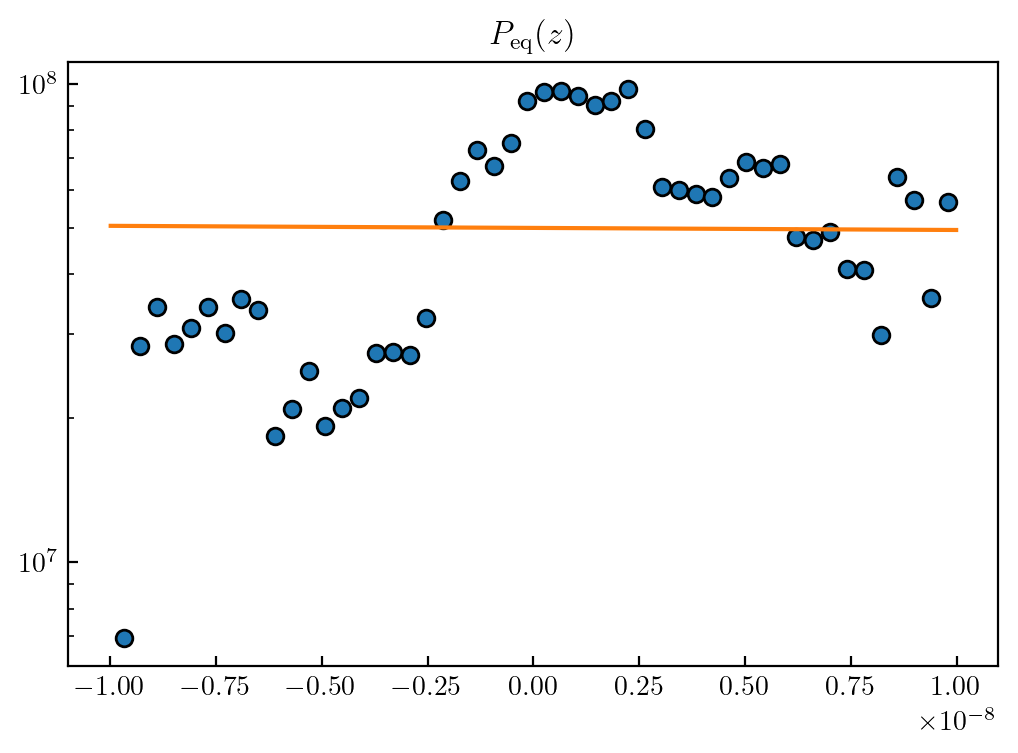

In [10]:
plt.plot(X,Y,"o", label=r"Simu")
plt.semilogy(zz, P_eq(zz)/quad(P_eq, -H, H)[0], label=r"Théorie")
plt.title(r"$P_\mathrm{eq}(z)$")

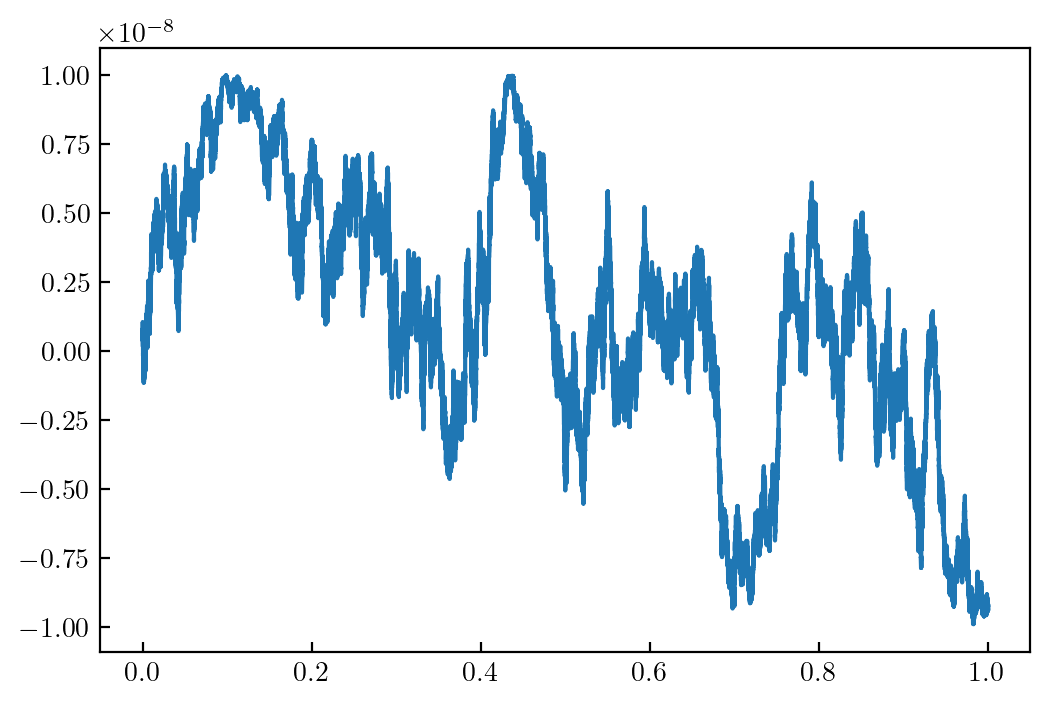

In [11]:
plt.plot(t, simu.z)

# Calcul de $\langle D_\perp(z) \rangle_z$ :

In [12]:
pdf_theo = simu.P_z_wall(zz) ## P_eq(z)
Peq_z = pdf_theo/np.trapz(pdf_theo, zz) ## Normalisation par N

Dz = (simu.kb*simu.T) / (gamma_z_eff(zz, a, eta, H)) 
mean_Dz_theo = np.trapz(Dz * Peq_z, zz)
print("<Dz>_theo/D_0 = {:.2f}".format(mean_Dz_theo/(kBT / simu.gamma)))

Dx = (simu.kb*simu.T) / (gamma_xy_eff(zz, a, eta, H)) 
mean_Dx_theo = np.trapz(Dx *Peq_z, zz)
print("<Dx>_theo/D_0 = {:.2f}".format(mean_Dx_theo/(kBT / simu.gamma)))

<Dz>_theo/D_0 = 0.00
<Dx>_theo/D_0 = 0.28


# Calcul du plateau de la MSD :

# Vérification MSD

In [13]:
list_dt_MSD = np.array([], dtype=int)
for i in range(len(str(Nt)) - 1):
    # Take just 10 points by decade.
    list_dt_MSD = np.concatenate(
        (
            list_dt_MSD,
            np.arange(10 ** i, 10 ** (i + 1), 10 ** i, dtype=int),
        )
    )

In [14]:
position = simu.z

NumberOfMSDPoint = len(list_dt_MSD)
msd = np.zeros(NumberOfMSDPoint)
for k, i in enumerate(tqdm(list_dt_MSD)):
    if i == 0:
        msd[k] = 0
        continue
    msd[k] = np.mean((position[i:]-position[:-i])**2)

100%|███████████████████████████████████████████| 63/63 [00:02<00:00, 31.49it/s]


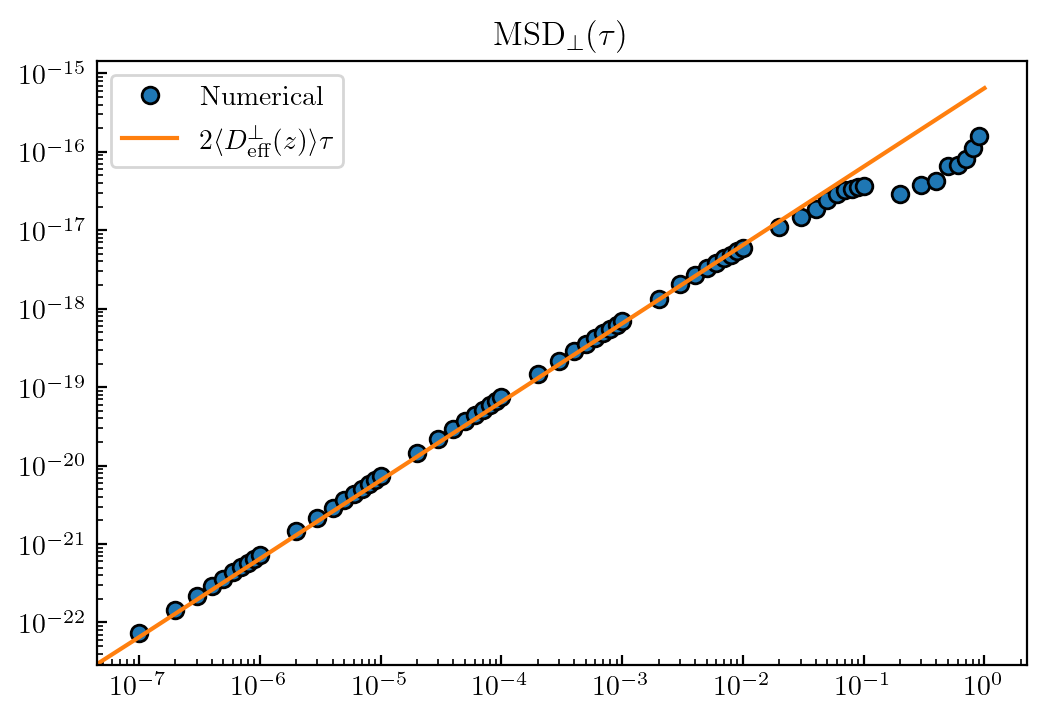

In [15]:
plt.loglog(t[list_dt_MSD], msd, "o", label=r"Numerical")
plt.plot(t, 2*mean_Dz_theo*t, "-", label=r"$2 \langle D_\mathrm{eff}^\perp(z) \rangle \tau$")
# plt.plot(tt, lB**2)
plt.title(r"MSD$_\perp(\tau)$")
plt.legend()

In [16]:
# MSD("z", Rs, dt, Nt, D_mean=mean_Dz_theo, lD=lD, lB=lB, space="wall")

In [17]:
position = simu.x

NumberOfMSDPoint = len(list_dt_MSD)
msd = np.zeros(NumberOfMSDPoint)
for k, i in enumerate(tqdm(list_dt_MSD)):
    if i == 0:
        msd[k] = 0
        continue
    msd[k] = np.mean((position[i:]-position[:-i])**2)

100%|███████████████████████████████████████████| 63/63 [00:02<00:00, 30.43it/s]


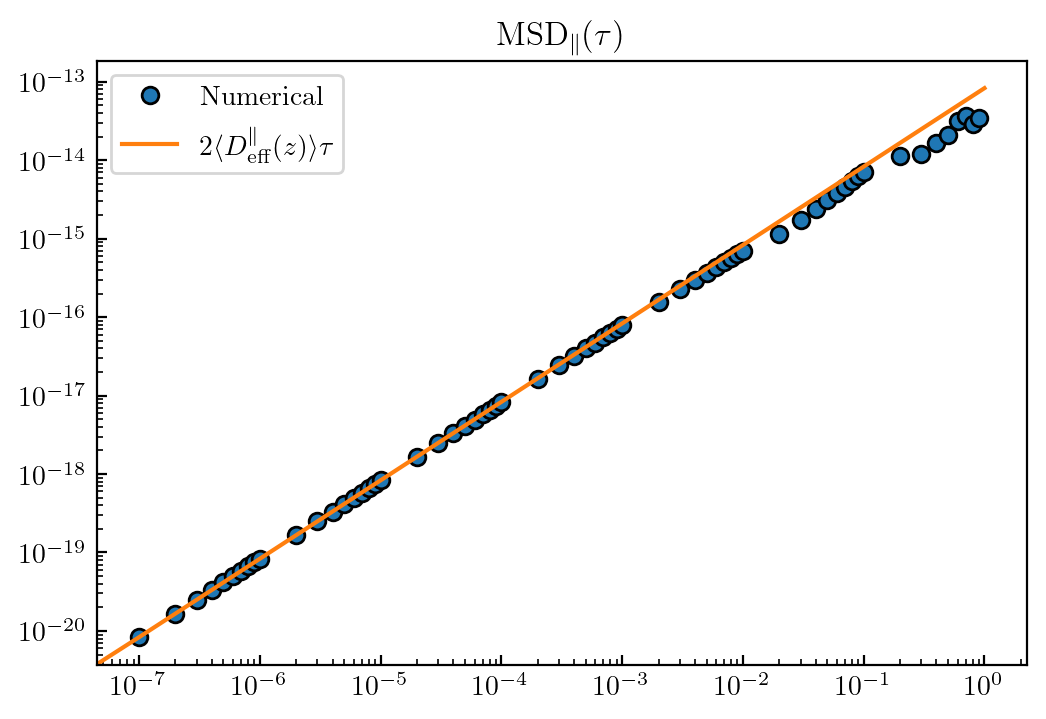

In [18]:
tt = np.linspace(0, dt*Nt*Nt_sub, Nt)
plt.loglog(t[list_dt_MSD], msd, "o", label=r"Numerical")
plt.plot(tt, 2*mean_Dx_theo*tt, "-", label=r"$2 \langle D_\mathrm{eff}^\|(z) \rangle \tau$")
plt.title(r"MSD$_\|(\tau)$")
plt.legend()

# Vérification cumulant 4 :

In [19]:
tau4, C4_simu = simu.Cumulant4("x", plot=False, output=True)

In [20]:
C4_simu

array([ 5.66532717e-45,  1.55020076e-44,  5.45005327e-44,  3.84275833e-44,
       -1.80373222e-44, -1.93526434e-43, -2.97656400e-43, -4.26710713e-43,
       -5.23456024e-43, -6.88680906e-43,  6.50044957e-42,  2.03061007e-41,
        3.86562169e-41,  4.24784007e-41,  1.33276394e-41,  1.00249991e-41,
        3.09017454e-41,  4.30546098e-41,  2.99892705e-41,  6.30439455e-40,
        3.36483798e-40, -8.03793294e-39, -1.86865645e-38, -2.56303609e-38,
       -3.83007997e-38, -5.51517822e-38, -6.68710448e-38, -6.50539824e-38,
       -3.34201335e-37, -1.90323941e-37, -9.72593857e-37,  9.03989289e-37,
        5.24048807e-36,  6.99571466e-36,  8.40099278e-36,  1.41936987e-35,
        1.64100836e-35,  8.46111703e-35,  6.69571543e-34,  1.57689332e-33,
        3.56742682e-33,  5.69520619e-33,  7.82312334e-33,  9.96187832e-33,
        1.14169915e-32])

In [21]:
tt_court = np.linspace(1e-5, dt*Nt*Nt_sub, 10000)
tt_long = np.linspace(1, dt*Nt*Nt_sub, 10000)

V_theo = lambda z: + kBT/lB*z
D_perp = lambda z: kBT/gamma_z_eff(z, a, eta, H)
D_para = lambda z: kBT/gamma_xy_eff(z, a, eta, H)
D_0 = lambda z: kBT/(6*np.pi*eta*a*np.ones(len(z)))

C4_long_theo = C4_long(Dpara=D_para, Dperp=D_perp, V=V_theo, kBT=kBT, a=-H, b=+H)
C4_court_theo = C4_court(Dpara=D_para, V=V_theo, kBT=kBT, a=-H, b=+H)

In [22]:
#Test sans potentielle
# V_test = lambda z: 0
# C4_long_test = C4_long(Dpara=D_para, Dperp=D_perp, V=V_test, kBT=kBT, a=-H, b=+H)

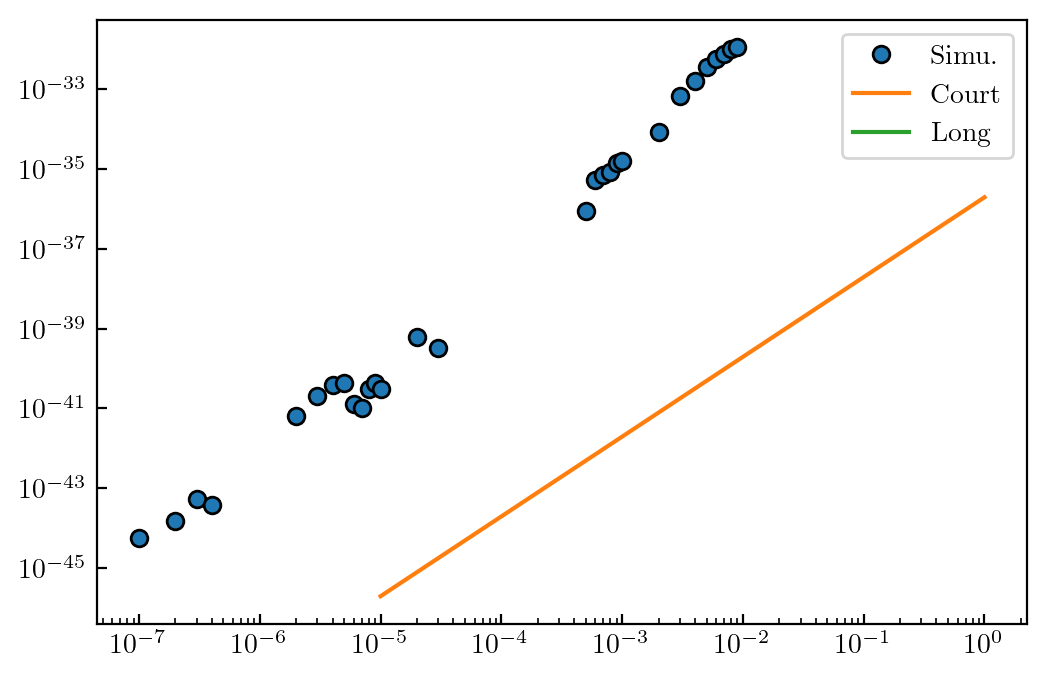

In [23]:
plt.loglog(tau4, (C4_simu), "o", label=r"Simu.")
plt.plot(tt_court, C4_court_theo*tt_court**2,label=r"Court")
plt.plot(tt_long, 24*C4_long_theo[0]*tt_long-24*C4_long_theo[1], label=r"Long")

# plt.plot(tt_long, 24*C4_long_test[0]*tt_long-24*C4_long_test[1], label=r"Long sans potentielle")
plt.legend()

In [24]:
t_cross = Cross_time(D_para, D_perp, V_theo, kBT, -H, +H)
print("tau_c = ", t_cross)

tau_c =  1.6102928436650241


In [25]:
1e1

10.0

In [26]:
stop

NameError: name 'stop' is not defined

## Test positions initiales

In [ ]:
x_0 = []
for i in range(10000):
    Simu = RigidWallOverdampedLangevin3D(dt=dt, Nt=1, a=a, H=H, lD=lD,)
    x_0.append(Simu.x0[2])
    
x_0 = np.array(x_0)

In [ ]:
hist, xx0 = np.histogram(x_0, bins=100, density=True)
xx0 = (xx0[:-1] + xx0[1:]) / 2

In [ ]:
plt.semilogy(zz, P_eq(zz)/quad(P_eq, -H, H)[0], "--", label=r"Théorie")
plt.plot(xx0, hist, "o", label=r"$z_0$ sur $10000$ tirages.")
plt.legend()

In [ ]:
!ls

In [ ]:
data = np.loadtxt("blabla.csv", delimiter = ",")

In [ ]:
plt.loglog(tau4, np.mean( data, axis=0), "o")